# 2.1.4. Bài tập thực hành 2
Xây dựng cây quyết định và rừng cây trên dữ liệu bệnh tiểu đường. Dữ liệu lấy từ
https://www.kaggle.com/code/tumpanjawat/diabetes-eda-random-forest-hp

## Bài làm


### 1: TẢI CÁC THƯ VIỆN VÀ DỮ LIỆU

In [1]:
# 1. Tải các thư viện
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
import graphviz # Thư viện để vẽ cây

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [4]:
# 2. Nạp dữ liệu
df = pd.read_csv('../data/2.1.4. Bài tập thực hành 2/diabetes_prediction_dataset.csv')
print("Tải dữ liệu thành công.")


Tải dữ liệu thành công.


### 2: TIỀN XỬ LÝ DỮ LIỆU

In [5]:
# Kiểm tra dữ liệu thiếu
print(f"Tổng giá trị thiếu (NaN): {df.isnull().sum().sum()}")

# Chuyển đổi các cột dạng chữ (object) sang dạng số
df_processed = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)

print("Các cột dữ liệu sau khi tiền xử lý:")
print(df_processed.columns)

# 3. Chuẩn bị dữ liệu cho tập train và tập test
# Định nghĩa biến mục tiêu (target)
target = 'diabetes'

# Định nghĩa các đặc trưng (features)
# Chúng ta lấy tất cả các cột ngoại trừ cột 'diabetes'
features = [col for col in df_processed.columns if col != target]

print(f"\nSố lượng features: {len(features)}")
print(f"Danh sách features: {features}")

# Chia dữ liệu
X = df_processed[features].values
y = df_processed[target].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=24)

print(f"Đã chia dữ liệu: {len(X_train)} mẫu train, {len(X_test)} mẫu test.")
print("--- Hoàn thành Tiền xử lý ---")

Tổng giá trị thiếu (NaN): 0
Các cột dữ liệu sau khi tiền xử lý:
Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes', 'gender_Male', 'gender_Other',
       'smoking_history_current', 'smoking_history_ever',
       'smoking_history_former', 'smoking_history_never',
       'smoking_history_not current'],
      dtype='object')

Số lượng features: 13
Danh sách features: ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'gender_Male', 'gender_Other', 'smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_not current']
Đã chia dữ liệu: 80000 mẫu train, 20000 mẫu test.
--- Hoàn thành Tiền xử lý ---


### NHIỆM VỤ 1: XÂY DỰNG CÂY QUYẾT ĐỊNH (max_depth = 2)

In [6]:
# 4. Xây dựng cây quyết định
dt = tree.DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

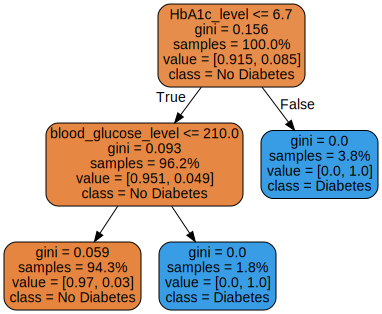

Vẽ cây quyết định thành công.


In [7]:

# 5. Hiển thị cây quyết định
dot_data = tree.export_graphviz(dt,
                                out_file=None,
                                filled=True,
                                rounded=True,
                                feature_names=features, # Thay đổi list features
                                proportion=True,
                                class_names=['No Diabetes', 'Diabetes']) # Thay đổi tên class
graph = graphviz.Source(dot_data)
# Hiển thị cây ngay trong Notebook
display(graph)
print("Vẽ cây quyết định thành công.")


### NHIỆM VỤ 2: TÌM THAM SỐ TỐI ƯU CHO CÂY QUYẾT ĐỊNH

In [8]:
# 2. Tạo cây và xác định các giá trị tham số
params = {'max_depth':[1, 2, 4, 6, 8, 10, 12]} # Giống bài mẫu
dt_cv = tree.DecisionTreeClassifier()

# (Sử dụng cv=3 thay vì cv=4 để chạy nhanh hơn, vì dữ liệu này lớn)
# (n_jobs=-1 để dùng tất cả CPU cho nhanh)
cv = GridSearchCV(dt_cv, param_grid=params, scoring='roc_auc',
                  n_jobs=-1, refit=True, cv=3, verbose=1,
                  error_score=np.nan,
                  return_train_score=True)

cv.fit(X_train, y_train)
print(f"Tham số 'max_depth' tốt nhất tìm được: {cv.best_params_}")

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Tham số 'max_depth' tốt nhất tìm được: {'max_depth': 10}


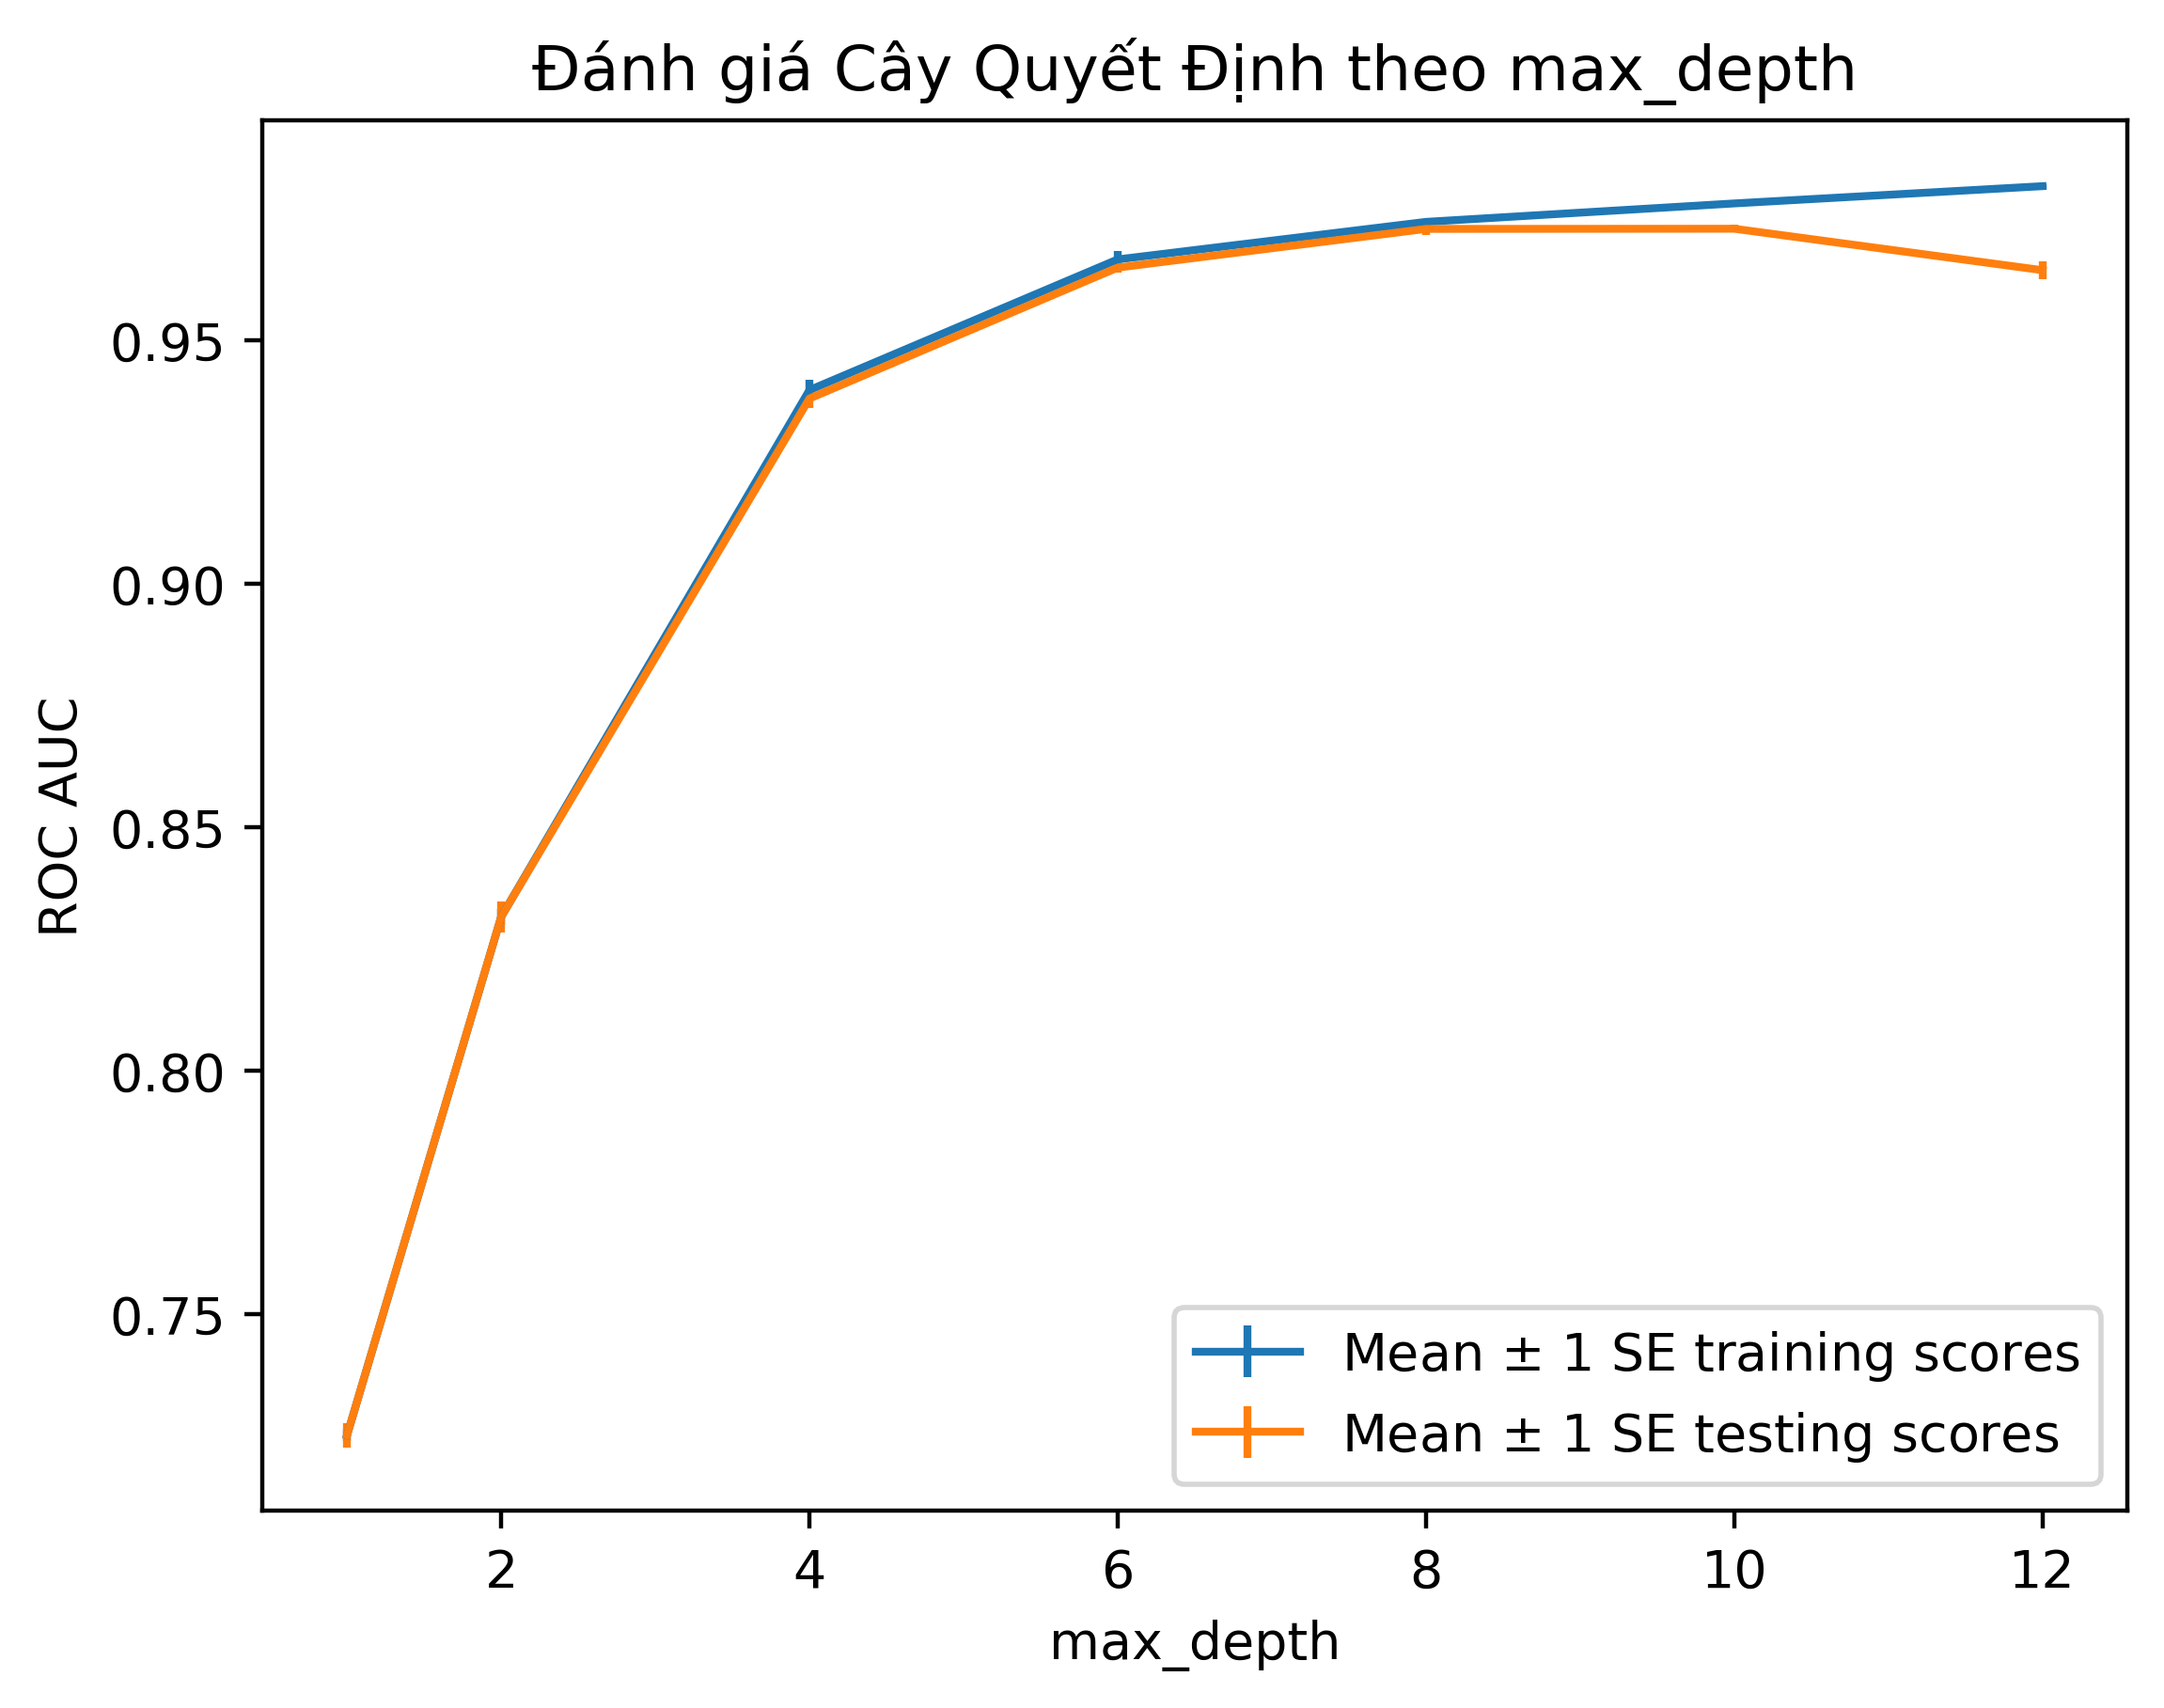

In [9]:
# 3. Vẽ biểu đồ đánh giá mô hình
cv_results_df = pd.DataFrame(cv.cv_results_)

plt.figure() # Tạo figure mới
ax = plt.axes()
ax.errorbar(cv_results_df['param_max_depth'],
            cv_results_df['mean_train_score'],
            yerr=cv_results_df['std_train_score']/np.sqrt(3), # cv=3
            label='Mean $\pm$ 1 SE training scores')
ax.errorbar(cv_results_df['param_max_depth'],
            cv_results_df['mean_test_score'],
            yerr=cv_results_df['std_test_score']/np.sqrt(3), # cv=3
            label='Mean $\pm$ 1 SE testing scores')
ax.legend()
plt.xlabel('max_depth')
plt.ylabel('ROC AUC')
plt.title('Đánh giá Cây Quyết Định theo max_depth')
plt.show()

### NHIỆM VỤ 3: XÂY DỰNG RỪNG CÂY (RANDOM FOREST)

In [11]:
# 2. Tạo rừng cây 
rf = RandomForestClassifier(
    n_estimators=10, 
    criterion='gini', 
    max_depth=3,
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0,
    max_features='sqrt', 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0,
    bootstrap=True, 
    oob_score=False, 
    n_jobs=None, # Sẽ đặt n_jobs=-1 trong GridSearchCV
    random_state=4, 
    verbose=0, 
    warm_start=False, 
    class_weight=None
)

In [12]:
# 3. Tìm tham số tối ưu (số lượng cây)
rf_params_ex = {'n_estimators':list(range(10,110,10))} # Giống bài mẫu

cv_rf_ex = GridSearchCV(rf, 
                        param_grid=rf_params_ex,
                        scoring='roc_auc', 
                        n_jobs=-1, # Dùng tất cả CPU
                        refit=True, 
                        cv=3, # Dùng cv=3 cho nhanh
                        verbose=1,
                        error_score=np.nan,
                        return_train_score=True)

cv_rf_ex.fit(X_train, y_train)
print(f"Tham số 'n_estimators' tốt nhất: {cv_rf_ex.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tham số 'n_estimators' tốt nhất: {'n_estimators': 10}


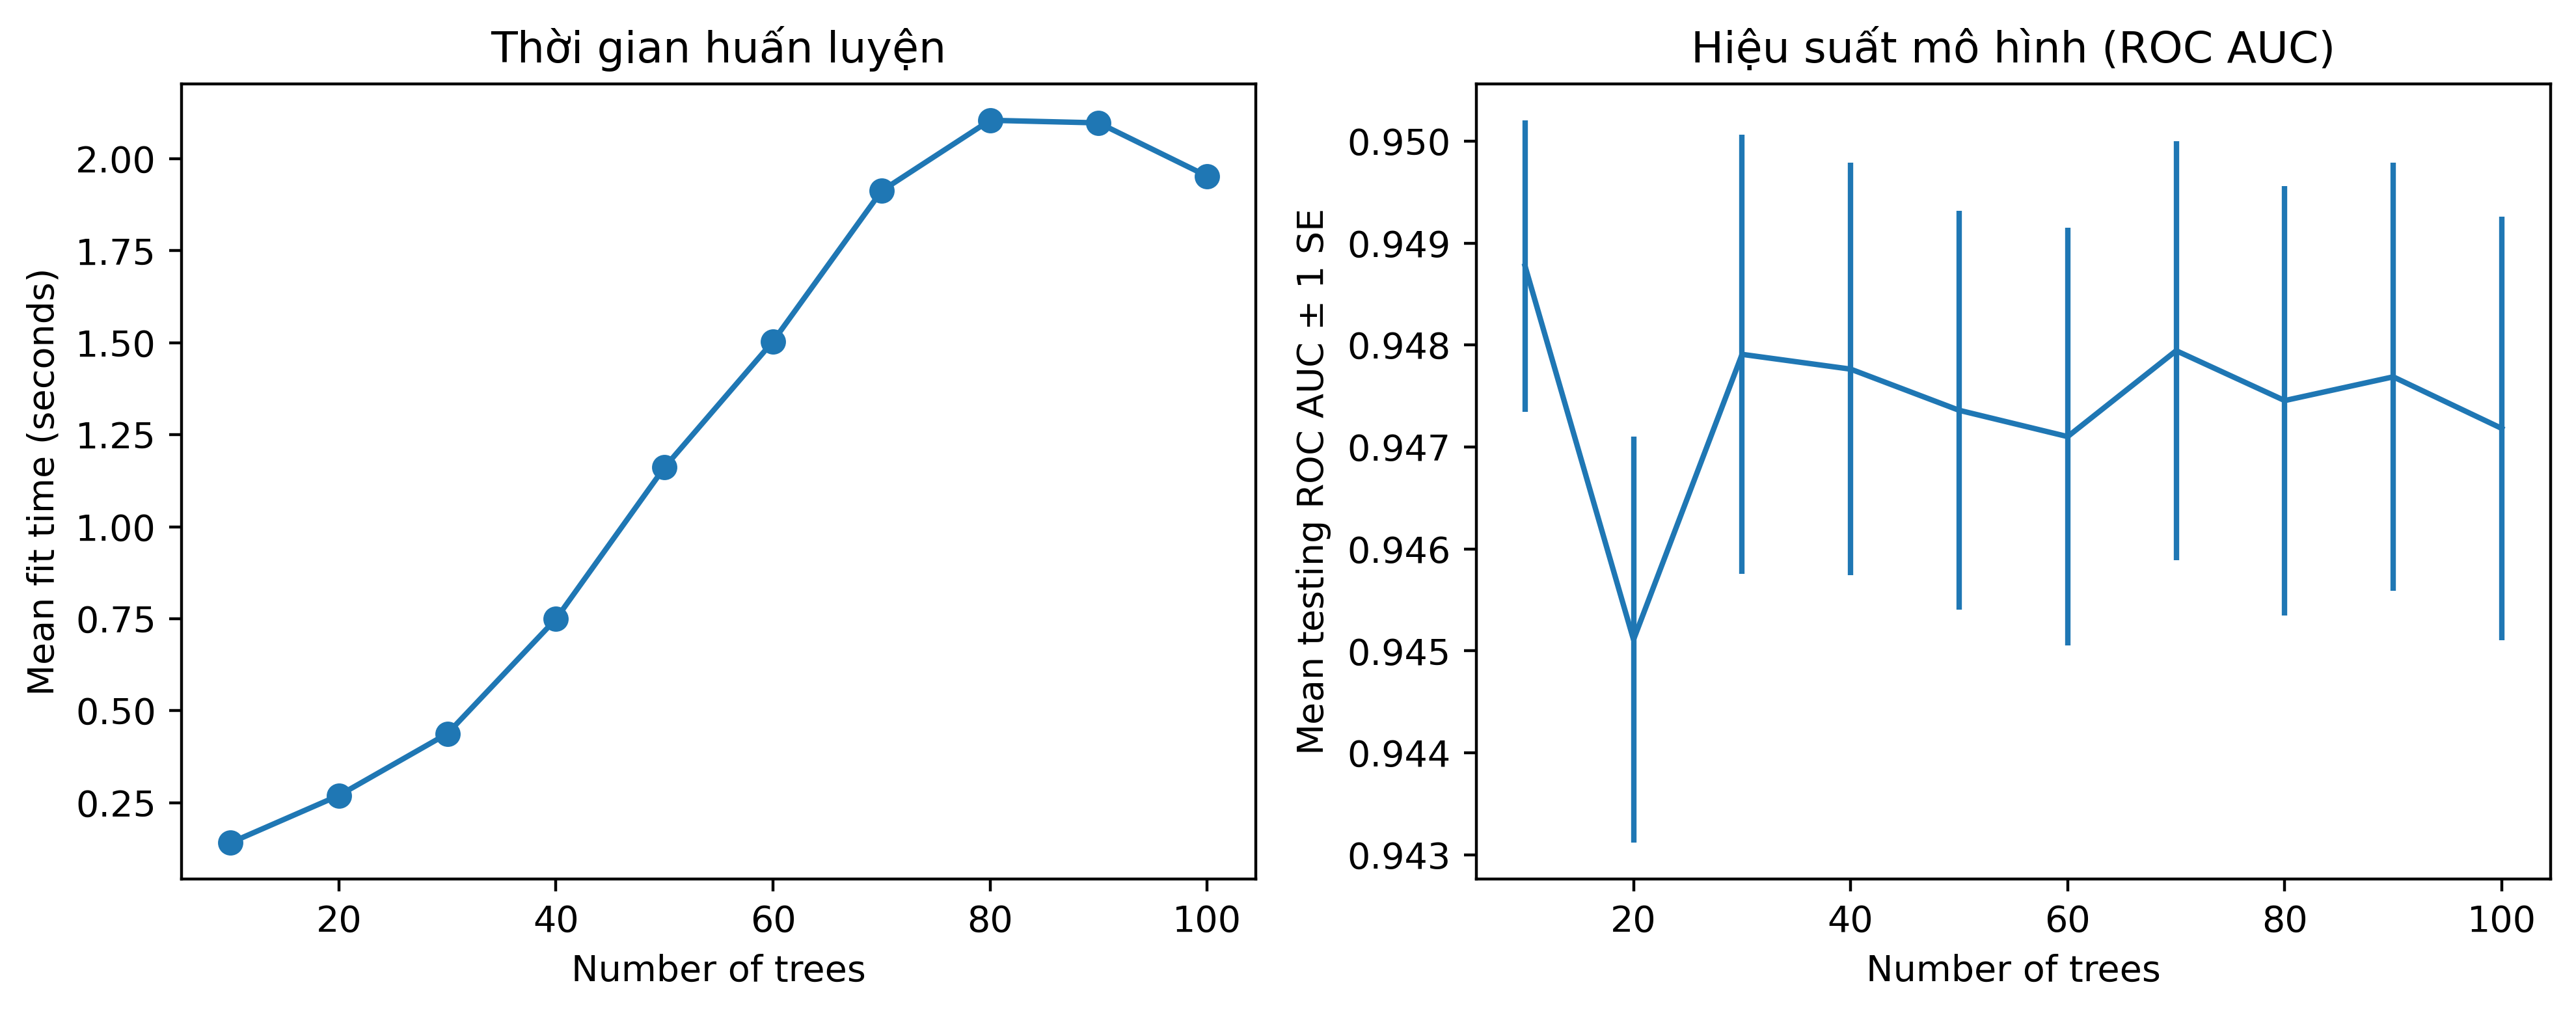

In [13]:
# 4. Vẽ biểu đồ đánh giá mô hình rừng cây
cv_rf_ex_results_df = pd.DataFrame(cv_rf_ex.cv_results_)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Biểu đồ 1: Thời gian huấn luyện
axs[0].plot(cv_rf_ex_results_df['param_n_estimators'],
            cv_rf_ex_results_df['mean_fit_time'],
            '-o')
axs[0].set_xlabel('Number of trees')
axs[0].set_ylabel('Mean fit time (seconds)')
axs[0].set_title('Thời gian huấn luyện')

# Biểu đồ 2: Điểm ROC AUC
axs[1].errorbar(cv_rf_ex_results_df['param_n_estimators'],
                cv_rf_ex_results_df['mean_test_score'],
                yerr=cv_rf_ex_results_df['std_test_score'] / np.sqrt(3)) # cv=3
axs[1].set_xlabel('Number of trees')
axs[1].set_ylabel('Mean testing ROC AUC $\pm$ 1 SE ')
axs[1].set_title('Hiệu suất mô hình (ROC AUC)')

plt.tight_layout()
plt.show()

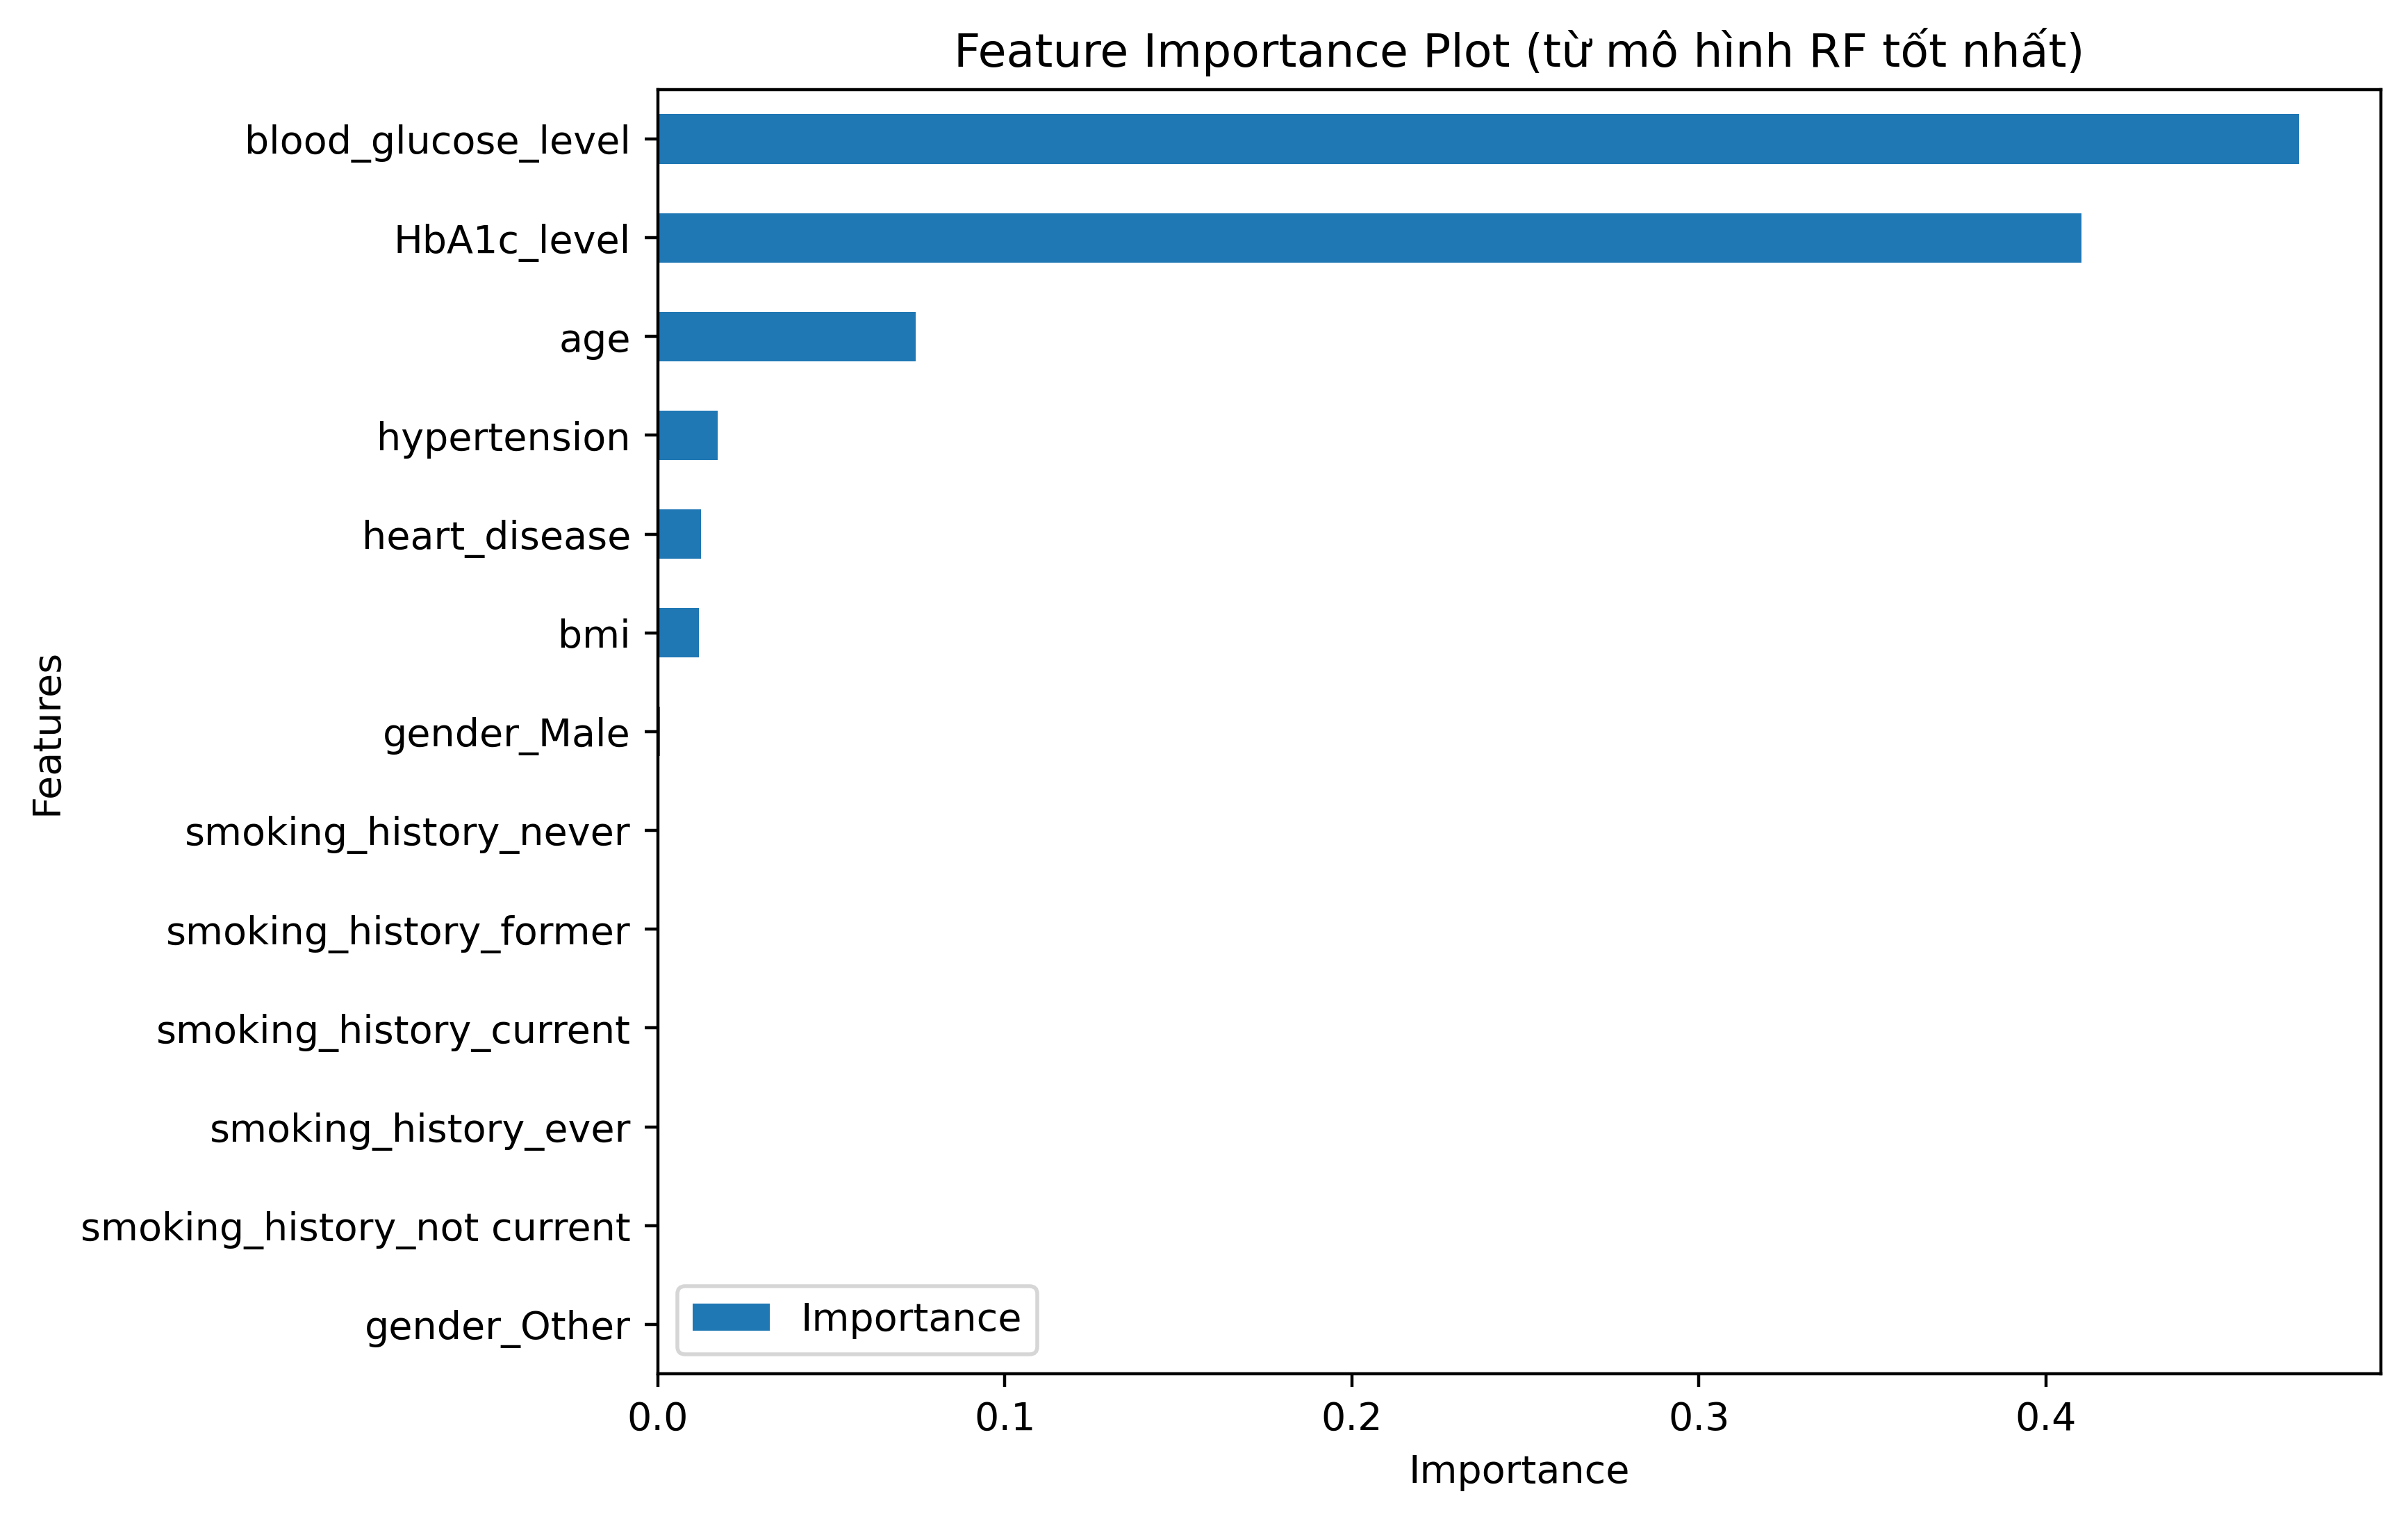

In [15]:
# 5. Xem mức độ quan trọng của feature
# Lấy mô hình tốt nhất từ GridSearchCV
best_rf = cv_rf_ex.best_estimator_

feat_imp_df = pd.DataFrame({
    'Importance': best_rf.feature_importances_
},
    index=features) # <-- Dùng list 'features' đã định nghĩa ở trên

# Sắp xếp và vẽ biểu đồ
feat_imp_df.sort_values('Importance', ascending=True).plot(kind='barh', figsize=(8, 6))
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot (từ mô hình RF tốt nhất)')
plt.show()

## Kết thúc

In [16]:
!jupyter nbconvert --to html "2.1.4. Bài tập thực hành 2.ipynb"

[NbConvertApp] Converting notebook 2.1.4. Bài tập thực hành 2.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 1182027 bytes to 2.1.4. Bài tập thực hành 2.html
